# Genetic Programing 1: Building A Representation

### We'll be using the basic expression-tree representation we've talked about so far. 

To make life a bit easier on our future selves, we'll be doing this with Python classes and inheritance. Don't worry if that means absolutely nothing to you, hopefully it will make more sense when we see it in action.

## First, we need to build a "Universal" class for a node in our expression tree. 

This is basically wrapping up what we except to be the same for every possible node in our genetic program representation. 

In [2]:
import numpy as np
from matplotlib import pyplot
import random

class GPNode:
    def __init__(self, node_type=None):
        self.parent = None
        self.node_type = node_type
        self.children = []
        self.depth = 0
        
    # let's put some of the work on keeping track of
    # relationships into this function, so we don't have
    # to keep updating references ourselves. 
    def add_child(self, child_node):
        child_node.depth = self.depth+1
        self.children.append(child_node)
        child_node.parent = self


## Now we can add our first "real" node class, a Const node -- something that holds a numerical value

### We'll add a few additional function calls here:
#### evaluate - 
This will take an input state (more on that later) and return the value this node evaluates to. For the Const nodes, that is just the value they've been assigned. 
#### pretty_print - 
This prints the node along with a number of indentions and its depth
#### deepcopy - 
This function creates a new instance of the Const node when called. This is a quark of the default behavior in Python of passing objects as references, so we want to make sure when we create new copies of nodes they're actually new copies and not just new "references" to the original. 

In [3]:
class GPConstNode(GPNode):
    def __init__(self, value=None):
        super().__init__(node_type="Const")
        self.const_value = value
    
    def evaluate(self, input_state):
        return self.const_value
        
    def pretty_print(self, indents=0):
        print('  '*indents + str(self.const_value) 
              + ' : ' + str(self.depth))
        
    def deepcopy(self):
        new_node = GPConstNode(value=self.const_value)
        new_node.depth = self.depth;
        return new_node
        

In [4]:
#Make a node and print it out...
const_node = GPConstNode(42)
const_node.pretty_print()

42 : 0


## Evaluate expects some state (in the form of a dictionary), more on this in a second. But, for now we can just give it something

In [4]:
const_node.evaluate()

TypeError: evaluate() missing 1 required positional argument: 'input_state'

In [5]:
# give evaluate a "dummy" state
const_node.evaluate({'blah'})

42

### Just a quick little demonstration about why deepcopy is needed!

In [6]:
const_node = GPConstNode(42)
new_node = const_node

new_node.const_value = "hah"
const_node.pretty_print()


hah : 0


### Our const_node's value was overwritten!! 

Let's try the same thing with a deepcopy.

In [7]:
const_node = GPConstNode(42)
new_node = const_node.deepcopy()

new_node.const_value = "hah"
const_node.pretty_print()

42 : 0


## Now that we have constant nodes, let's make a variable node class.
### Variable nodes are like our example in class, 'x', that can take on a value independent of the expression tree. 
This code should look mostly the same, where the only difference here is that the node gets a variable_name property, and that the evaluate function uses the input_state dictionary to pull out the value that should be assigned to the variable in this node. 
### An example: 
Let's say we have a variable node with variable_name = 'x'

When we evaluate this node, it's expecting a dictionary with an entry for 'x', e.g., {'x':42}.

The node will then evaluate to whatever 'x' is in the input_state dictionary. 


In [8]:
class GPVariableNode(GPNode):
    def __init__(self, variable_name=None):
        super().__init__(node_type="Variable")
        self.variable_name = variable_name
    
    def evaluate(self, input_state):
        return input_state[self.variable_name]
    
    def pretty_print(self, indents=0):
        print('  '*indents + str(self.variable_name)
              + ' : ' + str(self.depth))
        
    def deepcopy(self):
        new_node = GPVariableNode(variable_name = self.variable_name)
        new_node.depth = self.depth
        return new_node

### Let's run through the example with a real variable node!

In [9]:
var_node = GPVariableNode(variable_name='x')
var_node.pretty_print()

x : 0


In [10]:
var_node.evaluate({'x':42})

42

#### It doesn't matter what else is in this input_state dictionary, so long as there is a value for 'x' in this case.

In [11]:
var_node.evaluate({'x':42, 'y':128})

42

### Nodes (and indeed whole trees) can be evaluated over a range of values. For example, if we were trying to evolve a function that behaved in a particular way -- say sin(x) -- we would need to compare the output of the genetic program over a range of x values to the target function. 

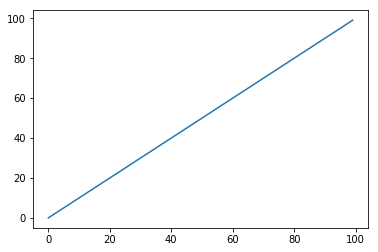

In [12]:
values = [var_node.evaluate({'x':x_val}) for x_val in range(100)]
pyplot.plot(values)
pyplot.show()

# Now to the fun(ction) nodes!
Function nodes are any node that require **parameters** to be evaluated. 
### We've been drawing these parameters as children nodes connected to the function node. This is the same way we'll be representing these in the code. 
Each function node has an associated number of arguments it should take (number of children nodes it should have). Remember, we added the code to handle parent/child relationships in our base GPNode class. 

Because the function nodes now depend on the value of their children, we must evaluate each child node before we can evaluate the function node. This processes of going through and calculating the result for children before we can calculate our own value is generally called **recursion**. 

We also use this process of recursion to pretty_print both this node and it's children. Note that the easiest way to spot recursion is when a function (e.g., evaluate()) is called within the body of its own code. 

In [13]:
class GPFunctionNode(GPNode):
    def __init__(self, arg_count, func_name=None, gp_function=None):
        super().__init__(node_type="Function")
        self.argument_count = arg_count
        self.gp_function = gp_function
        self.function_name = func_name
        
    def evaluate(self, input_state): 
        assert self.argument_count == len(self.children), \
        'Number of child nodes must match argument count'

        child_results = [c.evaluate(input_state) for c in self.children]
        return self.gp_function(*child_results)

    def pretty_print(self, indents=0):
        print('  '*indents + str(self.function_name) 
              + ' : ' + str(self.depth))
        
        for child in self.children:
            child.pretty_print(indents+1)
        
    def deepcopy(self):
        new_node = GPFunctionNode(self.argument_count, 
                                   self.function_name, 
                                   self.gp_function)
        new_node.depth = self.depth
        
        for child in self.children:
            new_node.add_child(child.deepcopy())
        
        return new_node

## Now lets see what an actual function node might look like. 
We can start easy and define the "+" operator.

In [14]:
# we'll need some terminal nodes to add together! 
var_node = GPVariableNode(variable_name='x')
const_node = GPConstNode(0.2)

# We can define a "gp_add" function to pass into our function node
def gp_add(x,y):
    return x+y

func_node = GPFunctionNode(arg_count=2, func_name="Add", gp_function=gp_add)

# But for these simple functions, lambdas are useful. They are unnamed
# functions defined inline like so:
func_node = GPFunctionNode(arg_count=2, func_name="Add", gp_function=lambda x, y: x+y)

func_node.pretty_print()

Add : 0


### Our function node doesn't have any children yet! 
That's because we didn't tell the node to use the two terminal nodes we created as arguments to the add function. We'll have to add them as children to do that. 

In [15]:
func_node.add_child(var_node)
func_node.add_child(const_node)
func_node.pretty_print()

Add : 0
  x : 1
  0.2 : 1


In [16]:
func_node.evaluate()

TypeError: evaluate() missing 1 required positional argument: 'input_state'

### Whoops, don't forget that input_state dictionary!

In [17]:
func_node.evaluate({'x':12})

12.2




# 1. Your turn!
### Add the required function nodes and terminal nodes to construct and evaluate the following expressions:
(**Note**: You should *actually* evaluate them using a few values of x)
- $x^2$
- $max(x, 2.2)$
- $1+x*7$
- $12\over{x}$


# 2. With the set of function nodes and terminal nodes you've just created, try writing code to generate some random program trees. 
This is a great way of debugging your representation to ensure you've satisfied the **closure** requirement, by the way!

# 3. If that was too easy, try adding these advanced function nodes:

- if(conditional_expression, true_expression, false_expression)
- "Automatically Defined Storage" Nodes -- These create new variables that can be used as terminal nodes based on the evaluation of a subtree.